# <center> Практические задания по цифровой обработке сигналов </center>
# <center> Вторая лабораторная работа </center>
# <center> Анализ сигналов </center>

In [1]:
import librosa
import numpy as np
import scipy 
import scipy.fft
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa.display
import librosa.filters
import hashlib

# Запретим numpy выполнять деление на 0
np.seterr(divide='raise', invalid='raise') 
%matplotlib inline

In [2]:
# Определим две функции для отрисовки сигнала. 
def draw_waveform(wav, sr, figsize=(14, 5)):
    # Отрисовка звукового сигнала во временной области
    plt.figure(figsize=figsize)
    librosa.display.waveplot(wav, sr=sr)

def draw_sig(frames, name=None, figsize=(14, 3)):
    # Отрисовка сигнала в виде "леденцов на палочке"
    plt.figure(figsize=figsize)
    plt.stem(frames)
    if name is not None:
        plt.legend([name])
    plt.xlabel("n")
    plt.ylabel("Energy")
    plt.show()
    

In [3]:
# Создадим несколько простых сигналов. Они нам понадобятся для дальшейшего тестирования
signals = {}

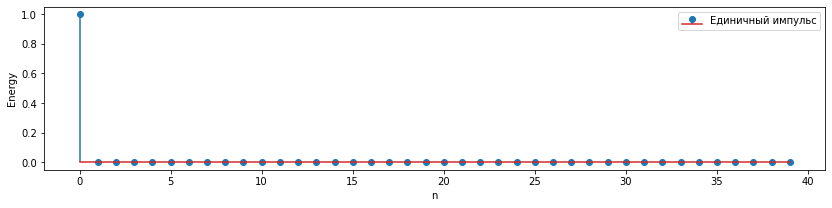

In [4]:
name = "Единичный импульс"
signals[name] = np.array([1] + [0]*39, dtype=float)
draw_sig(signals[name], name)

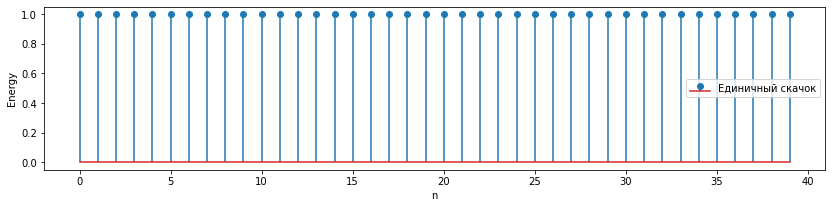

In [5]:
name = "Единичный скачок"
signals[name] = np.array([1]*40 ,dtype=float) 
draw_sig(signals[name], name)

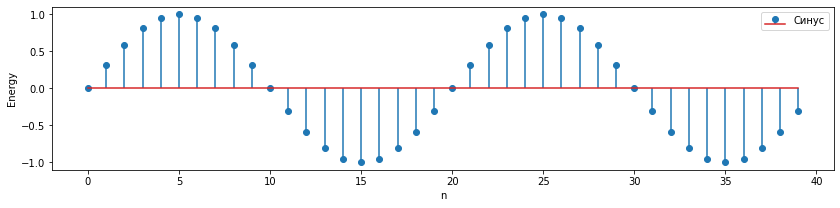

In [6]:
name = "Синус"
signals[name] = np.sin(np.pi * np.arange(40)/10)
draw_sig(signals[name], name)

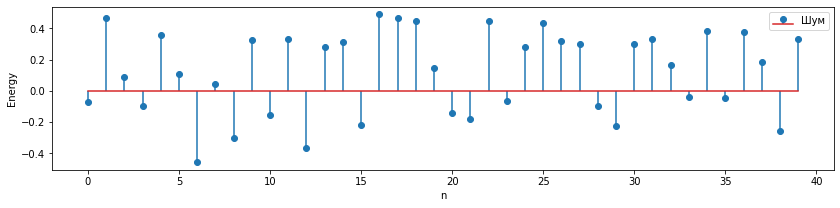

In [7]:
name = "Шум"
signals[name] = np.random.random(40)-0.5
draw_sig(signals[name], name)

-------------------------------
# Преобразование Фурье
Прежде, чем перейти к анализу сигналов, надо разобраться, что такое преобразование Фурье. 
> Преобразование Фурье (символ ℱ) — операция, сопоставляющая одной функции вещественной переменной другую функцию вещественной переменной. Эта новая функция описывает коэффициенты («амплитуды») при разложении исходной функции на элементарные составляющие — гармонические колебания с разными частотами (подобно тому, как музыкальный аккорд может быть выражен в виде суммы музыкальных звуков, которые его составляют). [Wiki](https://ru.wikipedia.org/wiki/%D0%9F%D1%80%D0%B5%D0%BE%D0%B1%D1%80%D0%B0%D0%B7%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%A4%D1%83%D1%80%D1%8C%D0%B5)



Формула прямого дискретного преобразования Фурье (ДПФ, Discrete Fourier Transform, DFT)):
$$ X_k = \sum_{n=0}^{N-1} x_n * e^{2i\pi k n/N} $$


# Задание 1 (2 балла)
Реализовать дискретное преобразование Фурье. Сравнить с реализацией scipy.fft.fft

In [8]:
def DFT(x):
    # YOUR CODE HERE
    return x @ np.exp(-2j * np.pi * np.linspace(0, 1, num=len(x), endpoint=False) * np.arange(len(x))[:, np.newaxis])

In [9]:
def test_DTF(x, transform=DFT):
    # Сравнение с библиотекой scipy
    scipy_result = scipy.fft.fft(x)
    curr_result = transform(x)
    if scipy_result.shape != curr_result.shape:
        print("TEST_FAILED")
        print(f"Your spectrogram shape is {curr_result.shape}. "
              f"Scipy spectrogram shape is {scipy_result.shape}")
        return -1
    if not np.allclose(curr_result, scipy_result):
        print("TEST FAILED")
        print(f"scipy spectrogram: {scipy_result}")
        print(f"Your DTF spectrogram: {curr_result}")
        print(f"Average diff is {np.mean(np.abs(scipy_result - curr_result))}")
        return -2
    print("TEST PASSED")
    return 0

for name, sig in signals.items():
    print(f"Checking '{name}'")
    assert test_DTF(sig) == 0, "Check you implementation"
print("All ok!")

Checking 'Единичный импульс'
TEST PASSED
Checking 'Единичный скачок'
TEST PASSED
Checking 'Синус'
TEST PASSED
Checking 'Шум'
TEST PASSED
All ok!


Класическое ДПФ имеет существенный недостаток - сложность алгоритма $O(N^2)$. На данный момент существуют чуть более сложные реализации преобразования Фурье, которые избавляются от квадратичной сложности. Например, алгоритм быстрого преобразования Фурье (Fast Fourier Transform, FFT) имеет сложность $O(N log(N))$, что делает его значительно более быстрым на длинных последовательностях. 

# Задание 1.1* (1 балл)
Реализовать быстрое преобразование Фурье. Сравнить с scipy.fft.fft

In [10]:
def FFT(x):
    # YOUR CODE HERE
    len_x = len(x)
    if len_x <= 6:
        return  x @ np.exp(-2j * np.pi * np.linspace(0, 1, num=len_x, endpoint=False) * np.arange(len_x)[:, np.newaxis])
    first = FFT(x[::2])
    second = FFT(x[1::2])
    compl = np.exp(-2j * np.pi * np.linspace(0, 1, num=len_x, endpoint=False))
    return np.concatenate([first + compl[:(len_x // 2)] * second,
                           first + compl[(len_x // 2):] * second])

In [11]:
for name, sig in signals.items():
    print(f"Checking '{name}'")
    assert test_DTF(sig, transform=FFT) == 0, "Check you implementation"
print("All ok!")

Checking 'Единичный импульс'
TEST PASSED
Checking 'Единичный скачок'
TEST PASSED
Checking 'Синус'
TEST PASSED
Checking 'Шум'
TEST PASSED
All ok!


# Амплитудный и фазовый спектры
Поскольку преобразование Фурье определено в комплекстной области, анализировать результат напрямую проблематично. Для анализа сигналов принято разбивать результат преобразования Фурье на два спектра: амплитудный и фазовый. Амплитудный показывает, как меняется модуль сигнала, а фазовый - как меняется угол, образуемый на комплексной плоскости. 
# Задание 2 (1 балл)

Реализовать функции построения амплитудного и фазового спектра

In [12]:
#функция построения амплитудного спектра
def get_amplitude_from_spec(spec):
    # YOUR CODE HERE
    return np.absolute(spec)

#функция построения фазового спектра
def get_phi_from_spec(spec):
    return np.angle(spec)

In [13]:
def check_mean_var(sig, mean=None, var=None):
    if mean is not None and np.mean(sig) != mean:
        print(f"Bad mean. Expected {mean}, got {np.mean(sig)}")
        return False
    if var is not None and np.var(sig) != var:
        print(f"Bad var. Expected {var}, got {np.var(sig)}")
        return False
    return True

_spec = scipy.fft.fft(np.array([1]+[0]*10))
assert check_mean_var(get_amplitude_from_spec(_spec), 1.0, 0.0), \
    "Wrong Amplitude"
assert check_mean_var(get_phi_from_spec(_spec), 0.0, 0.0), \
    "Wrong Phase"

    
_spec = scipy.fft.fft(np.array([1]*10))
assert check_mean_var(get_amplitude_from_spec(_spec), 1.0, 9.0), \
    "Wrong  Amplitude"
assert get_amplitude_from_spec(_spec)[0] == 10, \
    "Wrong Amplitude"
assert get_phi_from_spec(_spec)[0] == 0, \
    "Wrong phase"

_spec = scipy.fft.fft(scipy.fft.ifft(np.array([0] + [10+5j]+[0]*6 + [10-5j])))
assert get_amplitude_from_spec(_spec).round(1)[1] == 11.2 , \
    "Wrong Amplitude. Make sure it is a complex number module."
assert get_phi_from_spec(_spec).round(1)[1] == 0.5 , \
    "Wrong Amplitude. Make sure it is an angle."

   
print("All OK!")

All OK!


In [14]:
# Определим еще одну функцию для отрисовки
# Теперь будем рисовать сигнал в частотной области
def draw_spec(spec, name=None, draw_A=True, draw_p=True, figsize=(14, 3)):
    if len(spec)<100:
        # Рисуем точки как "леденцы на палочках"
        draw_func = plt.stem
    else:
        # При большом N "леденцы" выглядят плохо, 
        # Поэтому будем рисовать огибающую функцию
        draw_func = plt.plot
    
    if draw_A:
        plt.figure(figsize=figsize)
        plt.title("Amplitude spectrum")
        spec_A = get_amplitude_from_spec(spec)
        draw_func(spec_A)
        plt.ylabel("Magnitude")
        plt.xlabel("n")
        if name is not None:
            plt.legend([name])
        plt.show()
        
    if draw_p:
        plt.figure(figsize=figsize)
        plt.title("Phase spectrum")
        phi = get_phi_from_spec(spec)
        draw_func(phi)
        plt.ylabel("Radian")
        plt.xlabel("n")
        if name is not None:
            plt.legend([name])
        plt.show()
    return 

# Задание 2.1 (0.5 балла)
Постройте спектры для всех сигналов из коллекции signals и ответьте на вопросы:
1. Почему амплитуда всех гармоник единичного импульса равна единице? 
1. Какие выводы можно сделать смотря на амплитудный спектр? А на фазовый? 
1. Как перевести номер отсчета в частоту?  
1. Что в фазовом спектре является полезной информацией, а что - шумом? Почему?

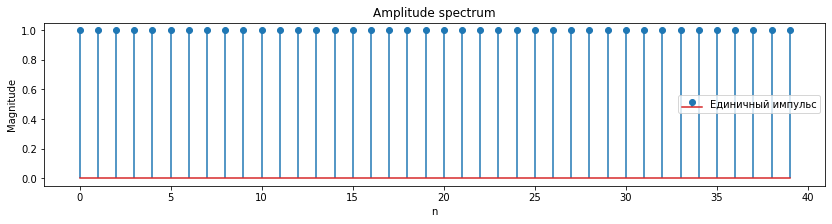

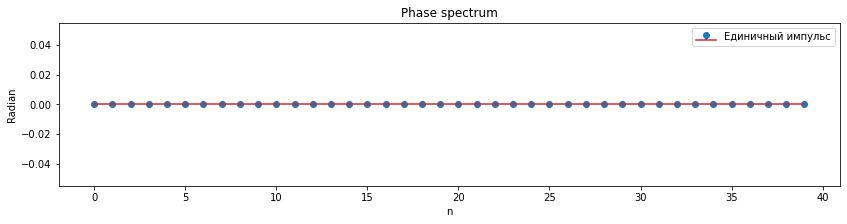

In [15]:
ind = 0
name = list(signals.keys())[ind]
draw_spec(DFT(signals[name]), name)

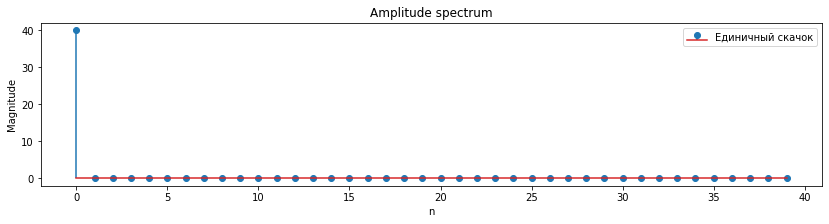

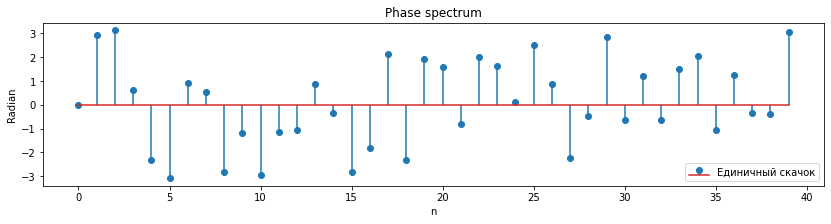

In [16]:
ind = 1
name = list(signals.keys())[ind]
draw_spec(DFT(signals[name]), name)

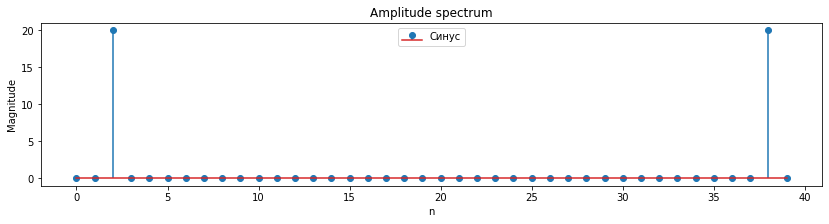

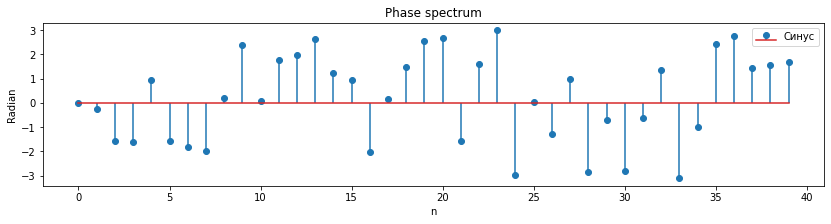

In [17]:
ind = 2
name = list(signals.keys())[ind]
draw_spec(DFT(signals[name]), name)

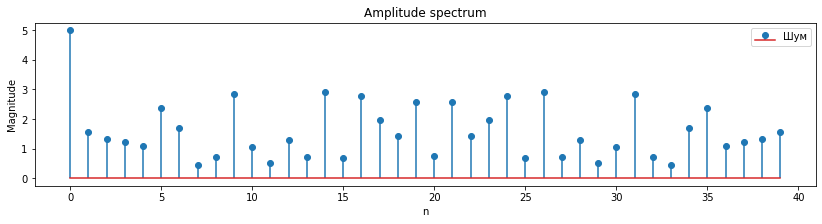

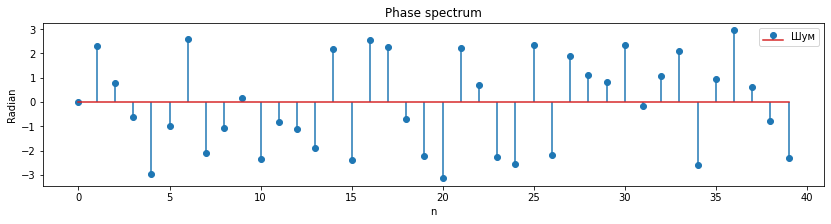

In [18]:
ind = 3
name = list(signals.keys())[ind]
draw_spec(DFT(signals[name]), name)

1. Свертка сигнала с единичным импульсом, не меняет амплитуду. Поэтому и амплитудный спектр единичного импульса равен единице во всей частотной области. 
2. По амплитудному спектру возможно выделить основные моды частот. По фазовому спектру можно скорее всего оценить уровень шума. 
3. Частоту возможно определить через отношение номера отсчёта на общее число отсчётов умноженное на частоту дискретизации. Необходимо еще умножить на 2pi если нужна циклическая частота 
4. В фазовом спектре вся информация является полезной, она позволяет вернутся к исходному сигналу. Так же пики сигнала, а также его размытие в частотной области позволяет оценить шум.

# Оконное преобразование Фурье
Преобразование Фурье делает переход из временной области в частотную, позволяя анализировать составляющие сигнал гармоники. Однако это не всегда удобно. В реальных сигналах зачастую составляющие их гармоники изменяются со временем. Например, каждая буква в слове имеет свой набор основных гармоник, и простое преобразование Фурье не сильно поможет нам определить, что было сказано. Для того, чтобы анализировать такие сигналы, обычно используется [Оконное преобразование Фурье](https://ru.wikipedia.org/wiki/Оконное_преобразование_Фурье). Такое преобразование позволяет анализировать гармоники сигнала в коротких промежутках времени и сохранить временную ось при построении спектрограммы.
# Задание 3 (2 балла)
Реализовать оконное преобразование Фурье, пользуясь только библиотеками numpy и scipy. Сравнить с librosa.stft


In [19]:
def STFT(x, n_fft=2048, hop_length=512, window='hann'):
    # Short-time Fourier transform
    # x - signal
    # n_fft - fft window size 
    # hop_length - step size between ffts
    # window - window type. See scipy.signal.get_window
    # return spectrogram 
    
    # YOUR CODE HERE
    x_len = len(x)
    wind = scipy.signal.get_window(window, n_fft)
    result = np.zeros((n_fft // 2 + 1, x_len // hop_length + 1), dtype=complex)
    for k in range(n_fft // 2 + 1):
        for hop_ind, hop in enumerate(range(0, x_len + 1, hop_length)):
            for window_ind, window in enumerate(range(- (n_fft // 2), n_fft // 2, 1)):
                vect = np.exp(-2j * np.pi * k * window_ind / n_fft)
                if window + hop < 0:
                    result[k][hop_ind] += x[-(window + hop)] * wind[window_ind] * vect               
                elif window + hop >= x_len:
                    result[k][hop_ind] += x[2 * x_len - (window + hop + 2)] * wind[window_ind] * vect  
                else:
                    result[k][hop_ind] += x[window + hop] * wind[window_ind] * vect
    return result

In [20]:
def test_stft(x, n_fft=2048, hop_length=512, window='hann'):
    librosa_result = librosa.stft(x, n_fft=n_fft, hop_length=hop_length, window='hann', center=True)
    result = STFT(x, n_fft=n_fft, hop_length=hop_length, window='hann')
    if librosa_result.shape != result.shape:
        print(f"Your shape {result.shape} != librosa stft shape {librosa_result.shape} ")
        return -1 
    if not np.allclose(librosa_result, result):
        print(f"Wrong results. Diff {np.abs(librosa_result-result)}")
        return -2
    return 0
        
for name, sig in signals.items():
    print(f"Checking '{name}'")
    for n_fft in (8, 4):
        for hop_length in (n_fft//4, n_fft//2):
            assert test_stft(sig, n_fft=n_fft, hop_length=hop_length)==0, \
                f"Test failed. Params n_fft {n_fft}. Hop_length {hop_length}"
    print("ok")
print("All ok!")

Checking 'Единичный импульс'
ok
Checking 'Единичный скачок'
ok
Checking 'Синус'
ok
Checking 'Шум'
ok
All ok!


In [21]:
# Определим функцию для отрисовки
def draw_stft(X, sr, figsize=(14, 5)):
    plt.figure(figsize=figsize)
    # X - комплекстная спектрограмма 
    # Для получения энергии достаточно взять модуль
    Xdb = librosa.amplitude_to_db(abs(X))
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.show()

# Анализ сигналов
Теперь можно приступить к анализу звуковых сигналов.
Во время анализа сигналов нам понадобятся все определенные выше инструменты. 


----------------------------------
## Анализ паровозного гудка
Начнем с простого сигнала, состоящего из нескольких основных гармоник и шума.

Len is 82175 ( ). Sample rate is 22050


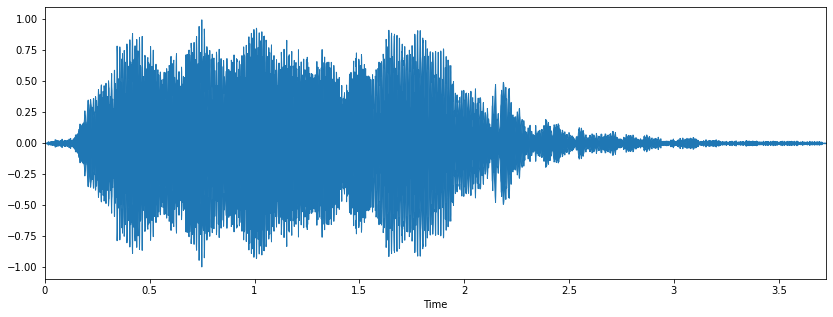

In [22]:
# Загрузим аудио файл с паровозным гудком
train_whistle, tw_sr = librosa.core.load("resources/train_whistle.wav")
print(f"Len is {len(train_whistle)} ( ). Sample rate is {tw_sr}")
player = ipd.Audio(train_whistle, rate=tw_sr)
ipd.display(player)
draw_waveform(train_whistle, sr=tw_sr)

Гудок паровоза в частотной области


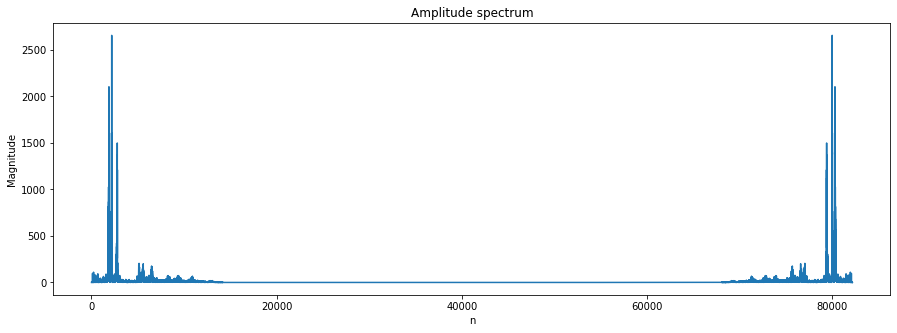

In [23]:
train_whistle_spec = scipy.fft.fft(train_whistle)
print("Гудок паровоза в частотной области")
draw_spec(train_whistle_spec, draw_p=False, figsize=(15,5))

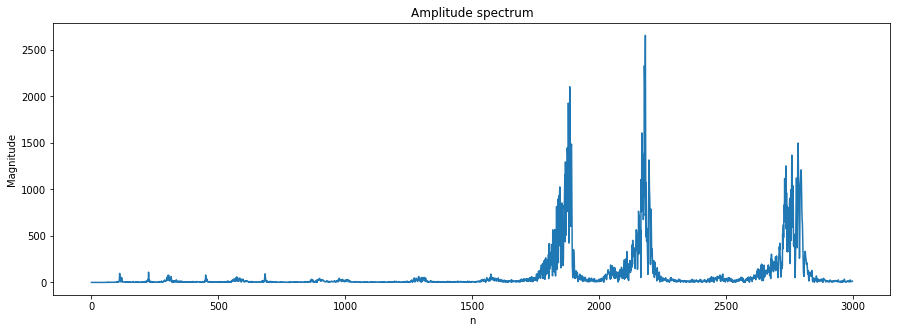

In [24]:
draw_spec(train_whistle_spec[:3000], draw_p=False, figsize=(15,5))

# Задание 4 (2 балла)
Определите 3 основные гармоники паровозного гудка.

Ответ округлите до двух знаков после запятой.


In [25]:
ampl = get_amplitude_from_spec(train_whistle_spec)
freq1 = (ampl[1500:2000].argsort()[-1] + 1500)
freq2 = (ampl[2000:2500].argsort()[-1] + 2000)
freq3 = (ampl[2500:3000].argsort()[-1] + 2500)

freq_list = [freq1, freq2, freq3]
task_answer = np.array(freq_list) * tw_sr / len(train_whistle)
print(freq_list, task_answer)

[1885, 2183, 2785] [505.80164284 585.76391847 747.29844843]


In [26]:
assert type(task_answer) == list or type(task_answer) == np.ndarray, \
        f"Wrong answer type. Expected list or numpy array. Got {type(task_answer)}"
assert len(task_answer) == 3, \
        f"Wrong len {len(task_answer)}."
assert (round(sum(task_answer)) == 1677 and round(np.var(task_answer)) == 1407) or \
        (abs(sum(task_answer)  - 1836) <= 3 and abs(np.var(task_answer) - 10153) <= 181), \
        f"Wrong freqs"
print("Correct!") 

Correct!


Теперь попробуйте сгенерировать сигнал, состоящий только из этих гармоник. Воспроизведите сигнал.

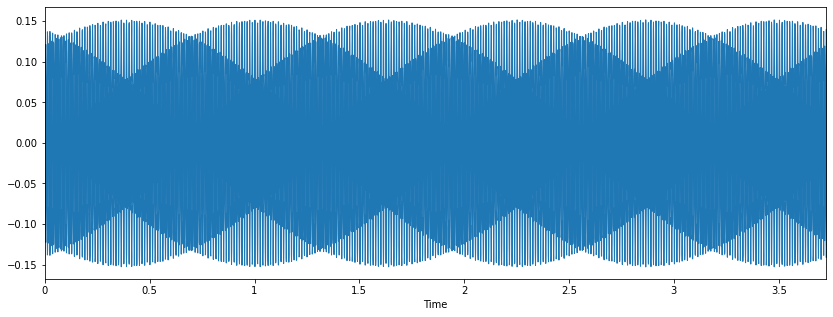

In [27]:
#YOUR CODE HERE
total_freq_list = freq_list.copy()
total_freq_list.extend(map(lambda x: len(train_whistle) - x, freq_list[::-1]))

train_whistle_spec_filtr = np.zeros(train_whistle_spec.shape, complex)
for ind in total_freq_list:
    train_whistle_spec_filtr[ind] = train_whistle_spec[ind]

filtr_signal = scipy.fft.ifft(train_whistle_spec_filtr)
ampl = get_amplitude_from_spec(filtr_signal)
draw_waveform(ampl, sr=tw_sr)

player = ipd.Audio(ampl, rate=tw_sr)
ipd.display(player)

# Анализ двухтонального многочастотного сигнала
Теперь расмотрим более сложный сигнал - [DTMF](https://en.wikipedia.org/wiki/Dual-tone_multi-frequency_signaling). Такие сигналы используются для автоматизации набора телефонного номера. 

# Задание 5 (2 балла)
В данном аудио закодирован трехзначный номер. Используя таблицу с [wiki]:(https://ru.wikipedia.org/wiki/DTMF) определите, что за номер закодирован.


Len is 243102. Sample rate is 22050


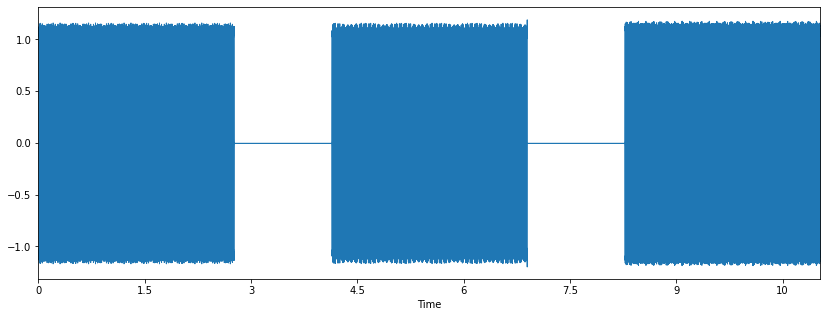

In [28]:
#dtmf.wav
dtmf, dtmf_sr = librosa.core.load("resources/dtmf.wav")
print(f"Len is {len(dtmf)}. Sample rate is {dtmf_sr}")
player = ipd.Audio(dtmf, rate=dtmf_sr)
ipd.display(player)
draw_waveform(dtmf, sr=dtmf_sr)

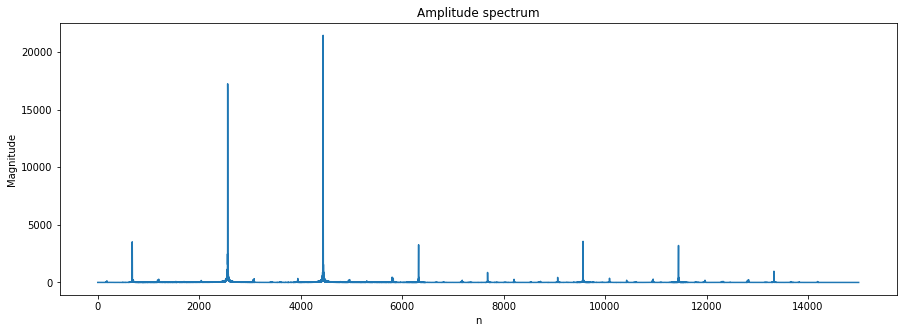

In [29]:
# YOUR CODE HERE
ft = []
for i in range(3):
    ft.append(scipy.fft.fft(dtmf[i * len(dtmf) // 3 : (i + 1) *len(dtmf) // 3]))  

draw_spec(ft[0][:15000], draw_p=False, figsize=(15,5))

In [30]:
freq_list = []
task_answer = []
for i in range(3):
    ampl = get_amplitude_from_spec(ft[i])
    freq = ampl[:10000].argsort()[-2:]
    task_answer.append(np.array(freq) * dtmf_sr / len(ft[i]))
task_answer = np.round(np.array(task_answer))
task_answer

array([[ 697., 1209.],
       [ 770., 1336.],
       [ 852., 1477.]])

%%html
<table class="standard">
<tbody><tr>
<td align="center"><a href="/wiki/%D0%A4%D0%B0%D0%B9%D0%BB:Dtmf1.ogg" title="Файл:Dtmf1.ogg">1</a></td>
<td align="center"><a href="/wiki/%D0%A4%D0%B0%D0%B9%D0%BB:Dtmf2.ogg" title="Файл:Dtmf2.ogg">2</a></td>
<td align="center"><a href="/wiki/%D0%A4%D0%B0%D0%B9%D0%BB:Dtmf3.ogg" title="Файл:Dtmf3.ogg">3</a></td>
<td align="center"><a href="/wiki/%D0%A4%D0%B0%D0%B9%D0%BB:DtmfA.ogg" title="Файл:DtmfA.ogg">A</a>
</td>
<th>697 <a href="/wiki/%D0%93%D1%86" class="mw-redirect" title="Гц">Гц</a>
</th></tr>
<tr>
<td align="center"><a href="/wiki/%D0%A4%D0%B0%D0%B9%D0%BB:Dtmf4.ogg" title="Файл:Dtmf4.ogg">4</a></td>
<td align="center"><a href="/wiki/%D0%A4%D0%B0%D0%B9%D0%BB:Dtmf5.ogg" title="Файл:Dtmf5.ogg">5</a></td>
<td align="center"><a href="/wiki/%D0%A4%D0%B0%D0%B9%D0%BB:Dtmf6.ogg" title="Файл:Dtmf6.ogg">6</a></td>
<td align="center"><a href="/wiki/%D0%A4%D0%B0%D0%B9%D0%BB:DtmfB.ogg" title="Файл:DtmfB.ogg">B</a>
</td>
<th>770 Гц
</th></tr>
<tr>
<td align="center"><a href="/wiki/%D0%A4%D0%B0%D0%B9%D0%BB:Dtmf7.ogg" title="Файл:Dtmf7.ogg">7</a></td>
<td align="center"><a href="/wiki/%D0%A4%D0%B0%D0%B9%D0%BB:Dtmf8.ogg" title="Файл:Dtmf8.ogg">8</a></td>
<td align="center"><a href="/wiki/%D0%A4%D0%B0%D0%B9%D0%BB:Dtmf9.ogg" title="Файл:Dtmf9.ogg">9</a></td>
<td align="center"><a href="/wiki/%D0%A4%D0%B0%D0%B9%D0%BB:DtmfC.ogg" title="Файл:DtmfC.ogg">C</a>
</td>
<th>852 Гц
</th></tr>
<tr>
<td align="center"><a href="/wiki/%D0%A4%D0%B0%D0%B9%D0%BB:DtmfStar.ogg" title="Файл:DtmfStar.ogg">*</a></td>
<td align="center"><a href="/wiki/%D0%A4%D0%B0%D0%B9%D0%BB:Dtmf0.ogg" title="Файл:Dtmf0.ogg">0</a></td>
<td align="center"><a href="/wiki/%D0%A4%D0%B0%D0%B9%D0%BB:Dtmf-.ogg" title="Файл:Dtmf-.ogg">#</a></td>
<td align="center"><a href="/wiki/%D0%A4%D0%B0%D0%B9%D0%BB:DtmfD.ogg" title="Файл:DtmfD.ogg">D</a>
</td>
<th>941 Гц
</th></tr>
<tr>
<th>1209 Гц</th>
<th>1336 Гц</th>
<th>1477 Гц</th>
<th>1633 Гц
</th></tr></tbody></table>

In [31]:
#кодировка соответствует
phone_number = [1, 5, 9]

In [32]:
assert type(phone_number) == list or type(phone_number) == np.ndarray, \
        f"Wrong answer type. Expected list or numpy array. Got {type(phone_number)}"
assert len(phone_number) == 3, \
        f"Wrong len {len(phone_number)}."
assert round(np.mean(phone_number)) == 5 and round(np.var(phone_number)) == 11 , \
        f"Wrong number"
assert hashlib.md5(''.join(map(str, phone_number)).encode()).hexdigest() == "140f6969d5213fd0ece03148e62e461e", \
        f"Wrong hash. How did you pass mean/var test?"
print("Correct!")   

Correct!
